# Exploring the Random Forest

# Libaries import and Function Define

In [4]:
# packages for basic python calculation
import pandas as pd
import numpy as np
import os

# warning ignore
import warnings
warnings.filterwarnings("ignore")

# packages for fft
import spectrum
from spectrum import Periodogram, data_cosine

# packages for ML
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score

# package for ploting
import matplotlib.pyplot as plt
plt.style.use('seaborn-talk')



# defind function for data readin
def load_data(folder_path = "../../data/buy/"):
    df_gp = pd.DataFrame()
    
    for filename in os.listdir(folder_path):
        if filename.endswith(".txt"): 
            stock = filename[0:4]
            # print("Loading stock data:", stock, ",")
            temp_df = pd.read_csv(os.path.join(folder_path, filename), delimiter= '\s+', header = None)
            temp_df.rename(columns={123:'rtn'}, inplace=True)
            temp_df = pd.concat([pd.Series([stock] * temp_df.shape[0], name = 'stock'), temp_df], axis=1)
            df_gp = pd.concat([df_gp, temp_df], ignore_index=True)
            df_gp.reset_index()
            continue
        else:
            continue

    
    return df_gp

Extra work due to personal interest: re-organize the whole as a class obj

In [15]:
class OSC_analyzing_pipeline():
    
    """
    This class is designed and modified for the Seahorse program. It is applicable for Random Forest
    Classifier originally.
    
    Attributes:
    ----------------------------------------------------------------------------
    self.data: the input dataset that we will be using for training and testing
    self.model: the classifier we want to explore
    self.osc_gp: subset for the oscillator data
    * new addition: self.stk: subset for original stock data
    self.macd_gp: subset for the macd data
    self.rtn_gp: subset for the return values
    self.label_gp: the output for training and testing (the reponse variable)
    
    self.psd
    self.smooth
    self.first_derivitive_macd
    self.second_derivitive_macd
    self.first_derivitive_osc
    self.second_derivitive_osc
    self.partial_smooth
    
    self.feature_result_df: the feature matrix and label generated from the feature_generator function, it can be used to visual which feature is participated in model training
    self.X_train: to visual and further call the training dataset
    self.X_test: to visual and further call the test dataset
    self.y_train: to visual and further call the training dataset
    self.y_test: to visual and further call the test dataset
    
    self.report: generate the report to compare the winning rate with the original test
    The class object also contains all the attributes belongs to the model/classifier originally.
    
    Functions:
    ----------------------------------------------------------------------------
    * new addition: EDA_visualization(): function for visualization the record
    psd_calculator(): function calculate the fft values, callable with return value to be visualized
    smooth_calculator(): function for calculating the smoothness value, already modified and can handle the amplitude changes
    derivative_calculator(): function for calculating the derivitive for macd and osc
    features_generator(): function to decide which feature can be used in the final model training, the input is True/False for certain feature to be involved. In this function, all three function above will be called
    model_train(): training the model based on the feature matrix
    
    """
    
    # define the init
    def __init__(self, data, model_selection = "RandomForest"):
        """
        Keyword argument:
        data -- (df) the input dataset for processing
        model -- (ML model) the classifier we are interested of, currently it is just the random forest
        """
        self.data = data
        if model_selection == "RandomForest":
            self.model = RandomForestClassifier()
        
        # seperate indicators and returns
        # name_gp = df_gp.iloc[:, 0]
        self.osc_gp = self.data.iloc[:, 1:42]
        self.stk_gp = self.data.iloc[:, 42:83]
        self.macd_gp = self.data.iloc[:, 83:124]
        self.rtn_gp = self.data.iloc[:, 124]
        self.label_gp = np.sign(self.rtn_gp)
        self.label_gp = self.label_gp.map({1: 1, -1: 0, 0:0})
        self.results_gp = self.label_gp.map({1: 'EARN', 0: 'LOSS'})
        self.label_gp = pd.DataFrame({"label": self.label_gp})
        
    
    def EDA_visualization(self, index, osc_ind = True, stk_ind = False, macd_ind = False):
        if osc_ind:
            # plot Oscillator
            plt.figure(figsize=(12,4))
            plt.plot(range(41),  self.osc_gp.iloc[index,:])
            plt.gca().invert_xaxis()
            plt.axhline(y=0.0, color = "black",linestyle='--')
            plt.ylabel("Oscillator")
            plt.xlabel("Time")
            plt.title("Oscillator 3-Day Time Series")
            plt.show()
        

        if stk_ind:
            # plot stock price
            plt.figure(figsize=(12,4))
            plt.plot(range(41), self.stk_gp.iloc[index,:])
            plt.legend()
            plt.gca().invert_xaxis()
            plt.ylabel("Stock Price")
            plt.xlabel("Time")
            plt.title("Stock Price 3-Day Time Series")
            plt.show()
    
        if macd_ind:
        # plot MACD
            plt.figure(figsize=(12,4))
            plt.plot(range(41),  self.macd_gp.iloc[index,:])
            plt.legend()
            plt.gca().invert_xaxis()
            plt.axhline(y=0.0, color = "black",linestyle='--')
            plt.ylabel("MACD")
            plt.xlabel("Time")
            plt.title("MACD 3-Day Time Series")
            plt.show()
        
    # define function for psd calculation
    def psd_calculator(self, NFFT = 100, name = "osc"):
        """
        calculate the psd seq as new feature
        """
        freq = []
        for i in range(self.osc_gp.shape[0]):
            data_osc = self.osc_gp.iloc[i,:]
            p = Periodogram(data_osc, NFFT=NFFT)
            temp_list = list(p.psd)
            freq.append(temp_list)
        col_name = []
        for i in range(int(NFFT/2)+1):
            col_name.append("freq"+str(i))
    
        psd_df = pd.DataFrame(freq, columns=col_name)
        psd_df.index = self.osc_gp.index
        
        return psd_df
    
    # define function to calculate smoothness more directly
    def smooth_calculator(self):
        smooth_list = []
        for i in range(self.osc_gp.shape[0]):
            amp = np.mean(abs(self.osc_gp.iloc[i,:]))
            if amp == 0:
                smooth_list.append(0)
            else:
                smooth_list.append(np.var(np.diff(self.osc_gp.iloc[i,:]))/amp)
        
        smooth = pd.DataFrame(smooth_list, columns=["smooth"]) 
        smooth.index = self.osc_gp.index

        return smooth
    
    # define the function to explore the influence of partial smoothness
    def smooth_partial(self):
        # get the nearest 10 points
        osc_10 = self.osc_gp.iloc[:,-10:]
        # calculate the smoothness of 10 points
        smooth_10 = []
        for i in range(osc_10.shape[0]):
            amp = np.mean(abs(osc_10.iloc[i,:]))
            if amp == 0:
                smooth_10.append(0)
            else:
                smooth_10.append(np.var(np.diff(osc_10.iloc[i,:]))/amp)
        
        
        # get the nearest 20 points
        osc_20 = self.osc_gp.iloc[:,-20:]
        smooth_20 = []
        for i in range(osc_20.shape[0]):
            amp = np.mean(abs(osc_20.iloc[i,:]))
            if amp == 0:
                smooth_20.append(0)
            else:
                smooth_20.append(np.var(np.diff(osc_20.iloc[i,:]))/(np.mean(abs(osc_20.iloc[i,:]))))
        
        # get the nearest 30 points
        osc_30 = self.osc_gp.iloc[:,-30:]
        smooth_30 = []
        for i in range(osc_30.shape[0]):
            amp = np.mean(abs(osc_30.iloc[i,:]))
            if amp == 0:
                smooth_30.append(0)
            else:
                smooth_30.append(np.var(np.diff(osc_30.iloc[i,:]))/(np.mean(abs(osc_30.iloc[i,:]))))
        
        partial_smooth = pd.DataFrame({"smooth_10": smooth_10,
                                      "smooth_20": smooth_20,
                                      "smooth_30": smooth_30,})
        
        partial_smooth.index = self.osc_gp.index
        return partial_smooth
    
    def first_derivative_calculator(self, space = 1, name = "macd"):
        
        
        if name == "macd":
            dy = []
            for i in range(self.macd_gp.shape[0]):
                y = pd.Series(self.macd_gp.iloc[i,:])
                temp_dy = list(np.gradient(y, space))
                dy.append(temp_dy)
    
            col_name = []
            for i in range(self.macd_gp.shape[1]):
                col_name.append(name + "deriv"+ str(i))
        
            deriv_df = pd.DataFrame(dy, columns=col_name) 
            deriv_df.index = self.macd_gp.index
            
        if name == "osc":
            dy = []
            for i in range(self.osc_gp.shape[0]):
                y = pd.Series(self.osc_gp.iloc[i,:])
                temp_dy = list(np.gradient(y, space))
                dy.append(temp_dy)
    
            col_name = []
            for i in range(self.osc_gp.shape[1]):
                col_name.append(name + "deriv"+ str(i))
        
            deriv_df = pd.DataFrame(dy, columns=col_name) 
            deriv_df.index = self.osc_gp.index
            
        return deriv_df
    
    def second_derivative_calculator(self, space = 1, name = "macd"):
        
        if name == "macd":
            
            ddy = []
            for i in range(self.first_deriv_macd.shape[0]):
                y = pd.Series(self.first_deriv_macd.iloc[i,:])
                temp_ddy = list(np.gradient(y, space))
                ddy.append(temp_ddy)
    
            col_name = []
            for i in range(self.first_deriv_macd.shape[1]):
                col_name.append(name + "sec_deriv"+ str(i))
        
            sec_deriv_df = pd.DataFrame(ddy, columns=col_name) 
            sec_deriv_df.index = self.first_deriv_macd.index
        
        if name == "osc":
            
            ddy = []
            for i in range(self.first_deriv_osc.shape[0]):
                y = pd.Series(self.first_deriv_osc.iloc[i,:])
                temp_ddy = list(np.gradient(y, space))
                ddy.append(temp_ddy)
    
            col_name = []
            for i in range(self.first_deriv_osc.shape[1]):
                col_name.append(name + "sec_deriv"+ str(i))
        
            sec_deriv_df = pd.DataFrame(ddy, columns=col_name) 
            sec_deriv_df.index = self.first_deriv_osc.index
        
        
        return sec_deriv_df
    
    def features_generator(self, psd=True, smooth=True, curvature=True, MACD_derivative = True, partial_smooth = True):
       
    # Feature order:
    # 0-40, osc;
    # 41-81, stk;
    # 82-122: macd;
    # 123-173: freq
    # 174: smooth
    # 175-215: first derivitive of osc
    # 216-256: second derivitive of osc
    # 257-297: first derivitive of macd
    # 297-338: second derivitive of macd
    
    
        Feature_matrix = self.data.iloc[:,1:-1]
        # calculate the fft frequencies distribution for the oscillator
        if psd==True:
            self.psd_osc = self.psd_calculator(NFFT = 100)
            Feature_matrix = pd.merge(Feature_matrix, self.psd_osc, left_index=True, right_index=True)
        
        # print(Feature_matrix)
        # Feature_matrix = pd.concat([Feature_matrix, psd_osc])
    
    # Factor for smoothness
        if smooth==True:
            self.smooth_osc = self.smooth_calculator()
            Feature_matrix = pd.merge(Feature_matrix, self.smooth_osc, left_index=True, right_index=True)
        
    # Factor for curvature
        if curvature == True:
        # calculate the dy for osc (way to study curvature)
            self.first_deriv_osc = self.first_derivative_calculator(name = "osc")
            Feature_matrix = pd.merge(Feature_matrix, self.first_deriv_osc, left_index=True, right_index=True)
        # calculate the ddy for osc
            self.second_deriv_osc = self.second_derivative_calculator(name = "osc")
            Feature_matrix = pd.merge(Feature_matrix, self.second_deriv_osc, left_index=True, right_index=True)
        
    # MACD dirivative
        if MACD_derivative == True:
            # calculate the dy for macd
            self.first_deriv_macd = self.first_derivative_calculator(name = "macd")
            Feature_matrix = pd.merge(Feature_matrix, self.first_deriv_macd, left_index=True, right_index=True)
        # calculate the ddy for macd
            self.second_deriv_macd = self.second_derivative_calculator(name = "macd")
            Feature_matrix = pd.merge(Feature_matrix, self.second_deriv_macd, left_index=True, right_index=True)
        # Feature_matrix = pd.concat([Feature_matrix, first_deriv_macd,second_deriv_macd])
    
    # partial smoothness
        if partial_smooth == True:
            self.partial_smooth = self.smooth_partial()
            Feature_matrix = pd.merge(Feature_matrix, self.partial_smooth, left_index=True, right_index=True)
        
        
        self.feature_result_df = pd.merge(Feature_matrix, self.label_gp, left_index=True, right_index=True)
    
    def model_train(self):
        
        Feature_matrix = self.feature_result_df.iloc[:,:-1]
        label_gp = self.feature_result_df.iloc[:,-1]
        
        #Split test set
        self.X, self.X_test, self.y, self.y_test = train_test_split(Feature_matrix, label_gp, test_size=0.2)

        #Split train/validation set
        # self.X_train, self.X_valid, self.y_train, self.y_valid = train_test_split(X, y, test_size=0.2)
        
        self.model.fit(self.X, self.y)
        
        scores = cross_val_score(self.model, self.X, self.y, cv=5)
        
        print("Validation Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
        print("Test Accuracy:", self.model.score(self.X_test, self.y_test))
        
        
        prob = self.model.predict_proba(self.X_test)
        # not quite familar and confortable with the log probability, just going to the normal probability
    
        # get the probbability of being 1
        proba_1 = []
        for probs in prob:
            proba_1.append(probs[1])
    
        df_result = pd.DataFrame({"predicted_prob":proba_1,
                             "true_label": self.y_test})
    
        df_count = df_result.groupby("predicted_prob").count()
        df_win = df_result.groupby("predicted_prob").sum()
    
        self.report = pd.DataFrame(df_win/df_count[["true_label"]])
        self.report["count"] = df_count
    
        self.report.columns = ["true_win_rate", "count"]
        
    #def feature_analyzing(self):
        

# Demo for the class object

In [3]:
data = load_data()

In [16]:
OSC_test = OSC_analyzing_pipeline(data, "RandomForest")

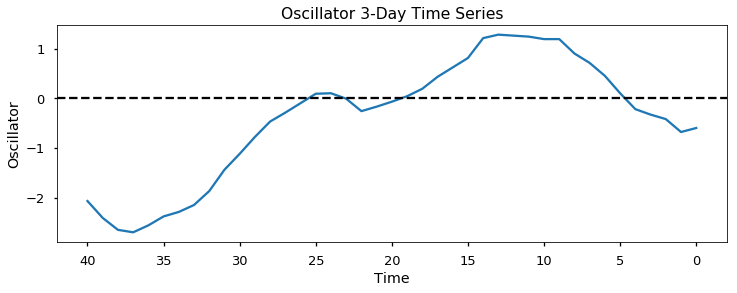

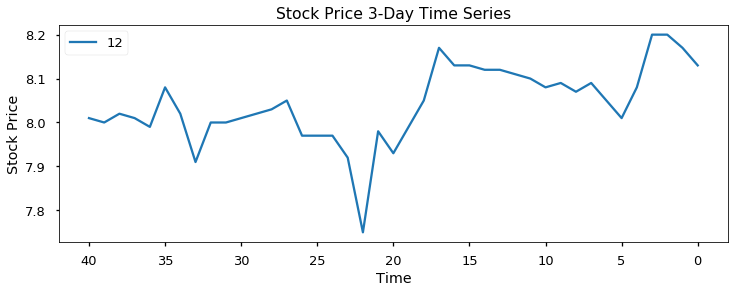

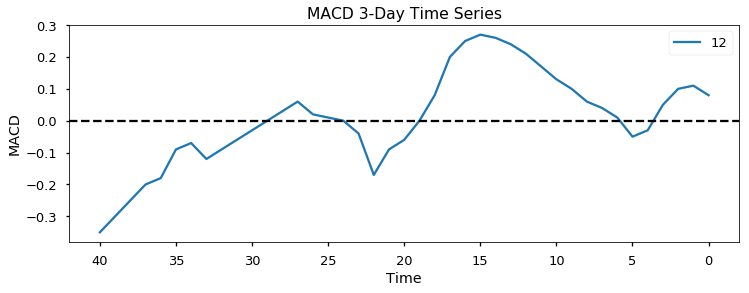

In [17]:
# test the eda function
OSC_test.EDA_visualization(12, True, True, True)

In [18]:
# partial smooth only considered in the Q&A section
OSC_test.features_generator(True, True, True, True, False)
# OSC_test.feature_result_df

NameError: name 'psd_calculator' is not defined

In [19]:
OSC_test.feature_result_df.head(5)

,0,1,2,3,4,5,6,7,8,9,...,macdsec_deriv32,macdsec_deriv33,macdsec_deriv34,macdsec_deriv35,macdsec_deriv36,macdsec_deriv37,macdsec_deriv38,macdsec_deriv39,macdsec_deriv40,label
0,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000000e+00,0.0000,0.00,0.0000,0.0000,0.0000,0.0,0.0,0.0,0
1,-0.11,-0.12,-0.04,0.04,0.00,0.00,0.00,0.00,0.00,0.00,...,0.000000e+00,0.0000,0.00,0.0000,0.0000,0.0000,0.0,0.0,0.0,0
2,-0.12,-0.13,-0.11,-0.10,-0.11,-0.12,-0.04,0.04,0.00,0.00,...,0.000000e+00,0.0000,0.00,0.0000,0.0000,0.0000,0.0,0.0,0.0,0
3,-0.15,-0.20,-0.12,-0.13,-0.11,-0.10,-0.11,-0.12,-0.04,0.04,...,0.000000e+00,0.0000,0.00,0.0000,0.0000,0.0000,0.0,0.0,0.0,1
4,-1.36,-1.56,-1.53,-1.34,-0.95,-0.53,0.24,1.05,1.62,2.24,...,3.469447e-18,0.0025,0.03,0.0125,-0.0275,-0.0175,0.0,0.0,0.0,0


In [20]:
OSC_test.model_train()

Validation Accuracy: 0.57 (+/- 0.00)
Test Accuracy: 0.5744409247789702


In [21]:
OSC_test.report

,true_win_rate,count
predicted_prob,,
0.000000,0.123636,275
0.100000,0.276112,967
0.166667,0.000000,1
0.199960,0.000000,1
0.200000,0.374258,2191
0.250000,1.000000,1
0.300000,0.397698,3910
0.340000,0.000000,1
0.350000,0.500000,2


We can observe there are some prob group with limited count as 1, we consider those group being the outliers. We removed them for future exploring.

Text(0,0.5,'True winning probability')

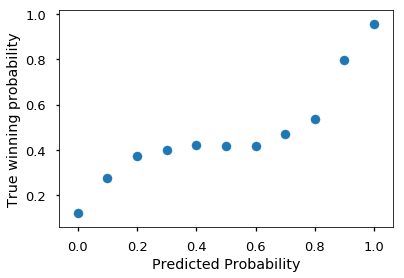

In [22]:
df_test_cleaned = OSC_test.report[OSC_test.report["count"] > 3]
plt.scatter(df_test_cleaned.index,df_test_cleaned[["true_win_rate"]])
plt.xlabel("Predicted Probability")
plt.ylabel("True winning probability")

In [23]:
OSC_test.model

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

# Q & A

## Which features are the most important?

In [24]:

feature_importances = pd.DataFrame({"features":OSC_test.X.columns,"importance":OSC_test.model.feature_importances_}).reset_index(drop=True).sort_values('importance',ascending=False)
#plt.bar(range(len(OSC_test.model.feature_importances_)),OSC_test.model.feature_importances_)

# Feature order:
    # 0-40, osc;
    # 41-81, stk;
    # 82-122: macd;
    # 123-173: freq
    # 174: smooth
    # 175-215: first derivitive of osc
    # 216-256: second derivitive of osc
    # 257-297: first derivitive of macd
    # 297-338: second derivitive of macd
    
col_index_list = feature_importances.index.tolist()
color = []
feature_type = []
for col in col_index_list:
    if col < 41:
        color.append("forestgreen")
        feature_type.append("osc")
    if (col > 40) & (col < 82):
        color.append("gold")
        feature_type.append("stk")
    if (col > 81) & (col < 123):
        color.append("blueviolet")
        feature_type.append("macd")
    if (col > 122) & (col < 174):
        color.append("blue")
        feature_type.append("freq")
    if (col == 174):
        color.append("crimson")
        feature_type.append("smoothness")
    if (col > 174) & (col < 216):
        color.append("coral")
        feature_type.append("d_osc")
    if (col > 215) & (col < 257):
        color.append("palegreen")
        feature_type.append("dd_osc")
    if (col > 256) & (col < 298):
        color.append("slateblue")
        feature_type.append("d_macd")
    if (col > 297) & (col < 339):
        color.append("royalblue")
        feature_type.append("dd_macd")

feature_importances["color"] = color
feature_importances["feature_type"] = feature_type

feature_importances.head(5)

,features,importance,color,feature_type
166,freq43,0.004405,blue,freq
163,freq40,0.004367,blue,freq
172,freq49,0.004347,blue,freq
138,freq15,0.004315,blue,freq
137,freq14,0.004221,blue,freq


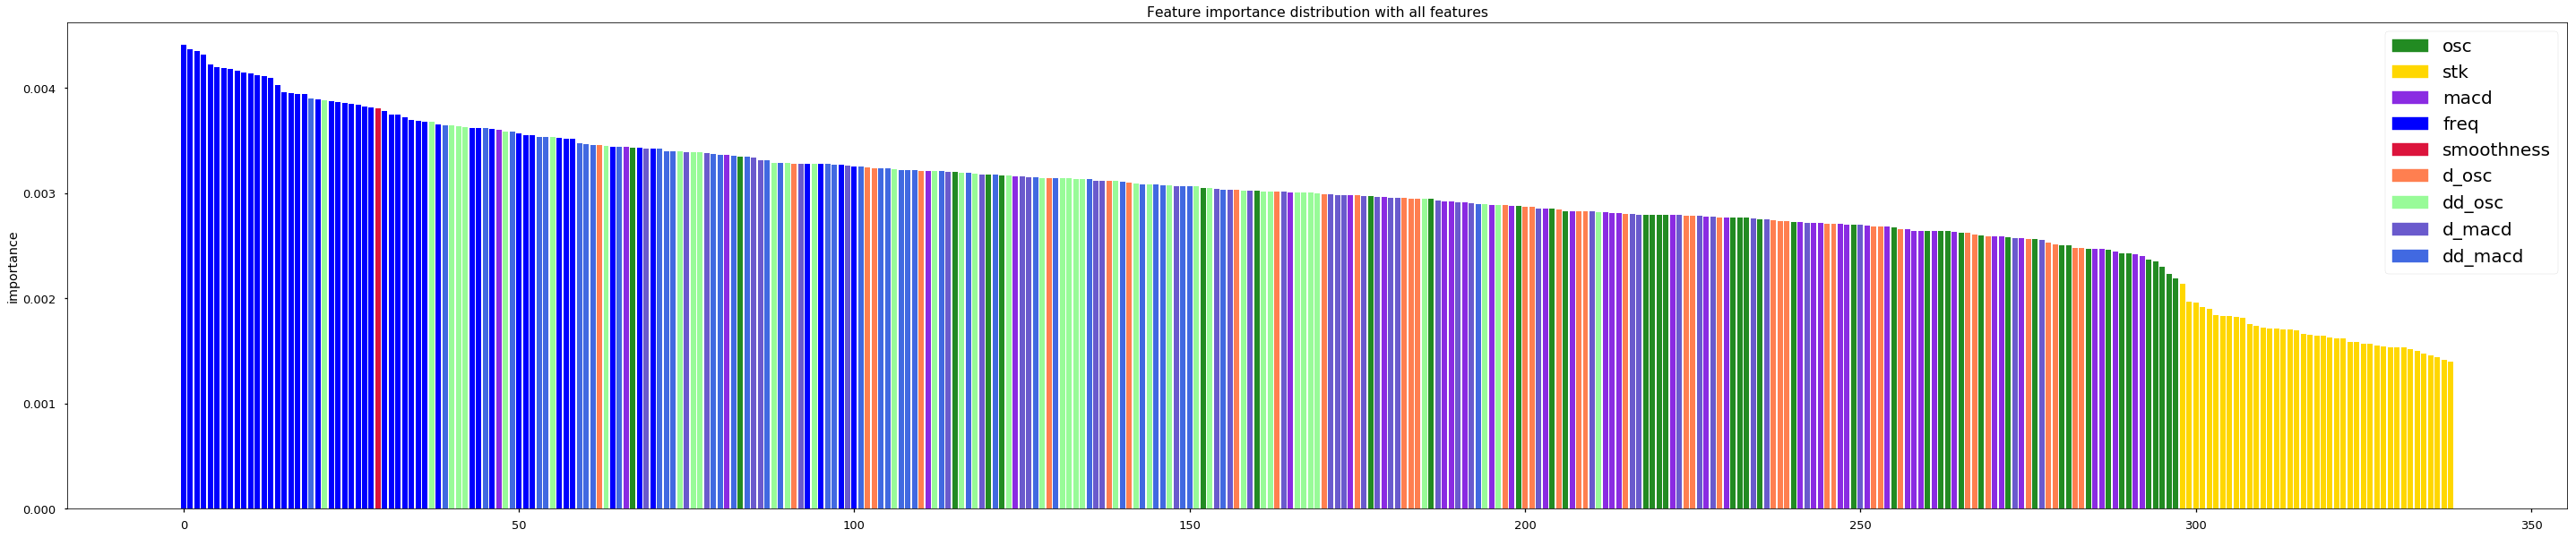

In [25]:
import matplotlib.patches as mpatches
plt.figure(figsize=(50,10))

plt.bar(range(len(feature_importances["importance"].tolist())), feature_importances["importance"].tolist(), color = color)

osc = mpatches.Patch(color='forestgreen', label='osc')
stk = mpatches.Patch(color='gold', label='stk')
macd = mpatches.Patch(color='blueviolet', label='macd')
freq = mpatches.Patch(color='blue', label='freq')
smooth = mpatches.Patch(color='crimson', label='smoothness')
d_osc = mpatches.Patch(color='coral', label='d_osc')
dd_osc = mpatches.Patch(color='palegreen', label='dd_osc')
d_macd = mpatches.Patch(color='slateblue', label='d_macd')
dd_macd = mpatches.Patch(color='royalblue', label='dd_macd')

plt.ylabel("importance")
plt.title("Feature importance distribution with all features")

plt.legend(handles=[osc,stk,macd,freq,smooth,d_osc,dd_osc,d_macd,dd_macd], prop={'size': 20})
plt.show()


# What about we reduce some features

1. Remove psd

In [27]:

OSC_no_psd = OSC_analyzing_pipeline(data, "RandomForest")
OSC_no_psd.features_generator(False, True, True, True, False)
OSC_no_psd.model_train()


Validation Accuracy: 0.57 (+/- 0.00)
Test Accuracy: 0.5754810647250721


In [28]:
OSC_no_psd.report.head()

,true_win_rate,count
predicted_prob,,
0.000000,0.165414,266
0.010417,0.000000,32
0.100000,0.322479,952
0.166667,0.500000,2
0.200000,0.386955,2269


Text(0.5,1,'prediction curve (without psd)')

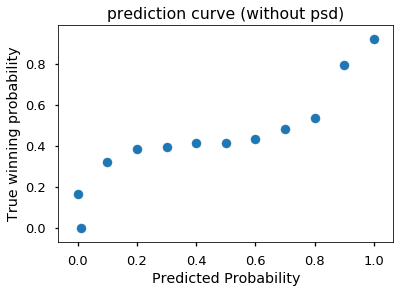

In [29]:
df_psd_cleaned = OSC_no_psd.report[OSC_no_psd.report["count"] > 5]
plt.scatter(df_psd_cleaned.index,df_psd_cleaned[["true_win_rate"]])
plt.xlabel("Predicted Probability")
plt.ylabel("True winning probability")
plt.title("prediction curve (without psd)")

Analyzing feature importance after psd is removed:


In [ ]:
# OSC_no_psd.X.iloc[0:5,247:288]
# OSC_no_psd.X.iloc[:,123:124]
# len(OSC_no_psd.model.feature_importances_)
#feature_importances = pd.DataFrame({"features":OSC_no_psd.X.columns,"importance":OSC_no_psd.model.feature_importances_}).reset_index(drop=True).sort_values('importance',ascending=False)
#col_index_list = feature_importances.index.tolist()

In [30]:
feature_importances = pd.DataFrame({"features":OSC_no_psd.X.columns,"importance":OSC_no_psd.model.feature_importances_}).reset_index(drop=True).sort_values('importance',ascending=False)
col_index_list = feature_importances.index.tolist()
color = []
feature_type = []
for col in col_index_list:
    if col < 41:
        color.append("forestgreen")
        feature_type.append("osc")
    if (col > 40) & (col < 82):
        color.append("gold")
        feature_type.append("stk")
    if (col > 81) & (col < 123):
        color.append("blueviolet")
        feature_type.append("macd")
    #if (col > 122) & (col < 174):
        #color.append("blue")
        #feature_type.append("freq")
    if (col == 123):
        color.append("crimson")
        feature_type.append("smoothness")
    if (col > 123) & (col < 165):
        color.append("coral")
        feature_type.append("d_osc")
    if (col > 164) & (col < 207):
        color.append("palegreen")
        feature_type.append("dd_osc")
    if (col > 206) & (col < 248):
        color.append("slateblue")
        feature_type.append("d_macd")
    if (col > 247) & (col < 288):
        color.append("royalblue")
        feature_type.append("dd_macd")

feature_importances["color"] = color
feature_importances["feature_type"] = feature_type

feature_importances.head()

,features,importance,color,feature_type
123,smooth,0.005167,crimson,smoothness
256,macdsec_deriv9,0.004677,royalblue,dd_macd
249,macdsec_deriv2,0.004600,royalblue,dd_macd
248,macdsec_deriv1,0.004562,royalblue,dd_macd
207,macdderiv1,0.004497,slateblue,d_macd


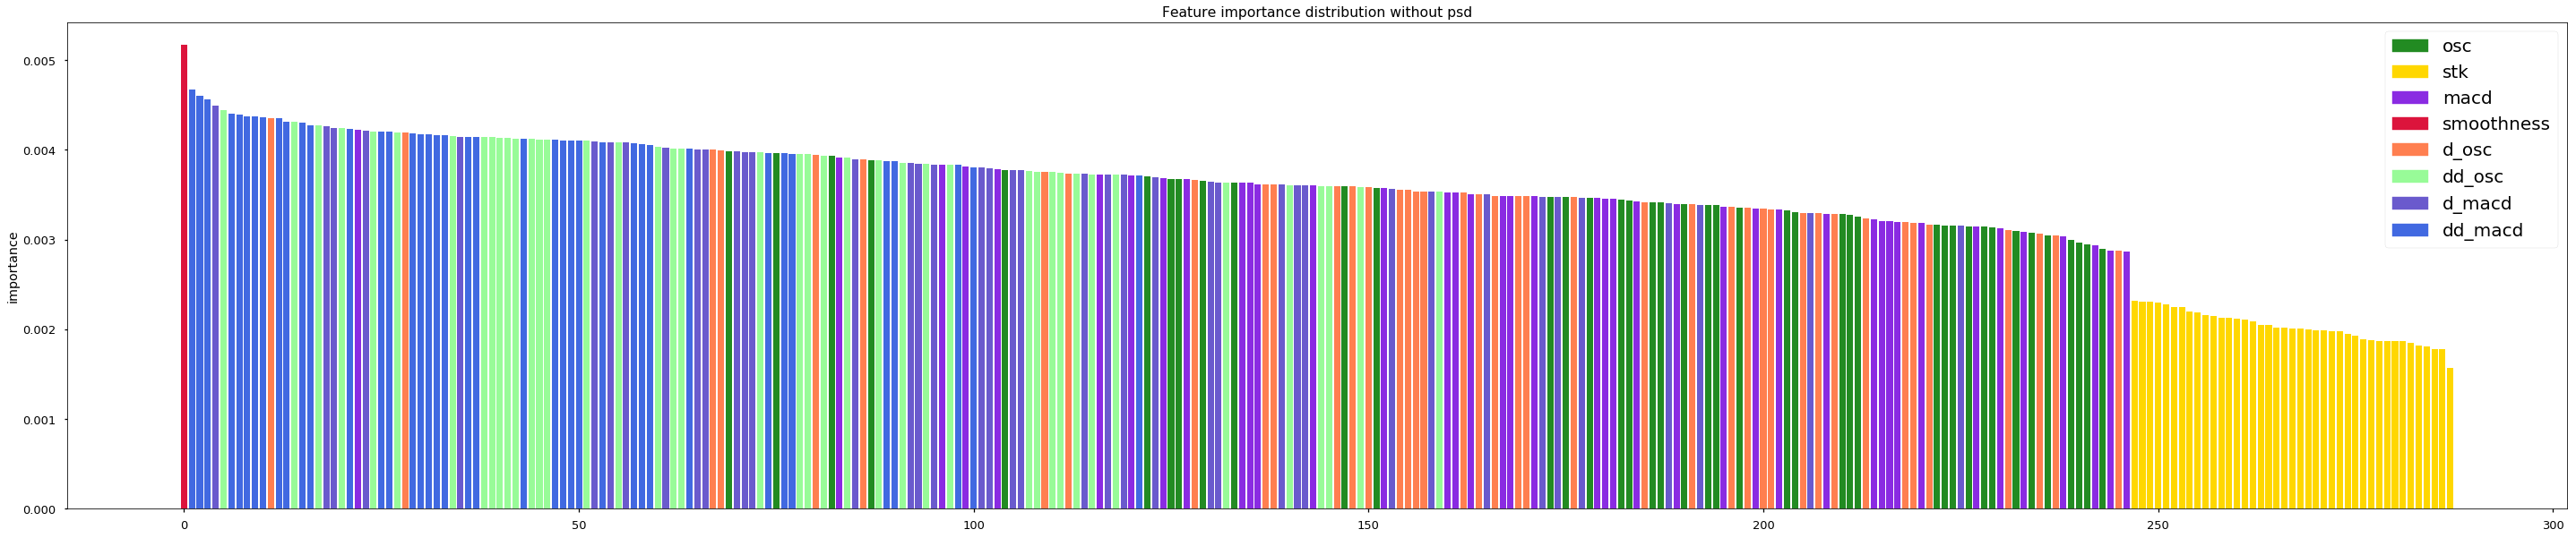

In [31]:
plt.figure(figsize=(50,10))

plt.bar(range(len(feature_importances["importance"].tolist())), feature_importances["importance"].tolist(), color = color)

osc = mpatches.Patch(color='forestgreen', label='osc')
stk = mpatches.Patch(color='gold', label='stk')
macd = mpatches.Patch(color='blueviolet', label='macd')
smooth = mpatches.Patch(color='crimson', label='smoothness')
d_osc = mpatches.Patch(color='coral', label='d_osc')
dd_osc = mpatches.Patch(color='palegreen', label='dd_osc')
d_macd = mpatches.Patch(color='slateblue', label='d_macd')
dd_macd = mpatches.Patch(color='royalblue', label='dd_macd')

plt.ylabel("importance")
plt.title("Feature importance distribution without psd")

plt.legend(handles=[osc,stk,macd,smooth,d_osc,dd_osc,d_macd,dd_macd], prop={'size': 20})
plt.show()

Even psd has higher importance, the output result doesn't change much.

2. Remove smoothness

In [32]:
OSC_no_psd_smooth = OSC_analyzing_pipeline(data, "RandomForest")
OSC_no_psd_smooth.features_generator(False, False, True, True, False)
OSC_no_psd_smooth.model_train()

Validation Accuracy: 0.57 (+/- 0.00)
Test Accuracy: 0.5784123682095409


In [33]:
OSC_no_psd_smooth.X.iloc[:5,120:125]

,120,121,122,oscderiv0,oscderiv1
59031,-0.63,-0.40,-0.25,-0.26,-0.120
69592,-1.05,-0.84,-0.61,0.00,0.000
88242,-0.10,-0.14,-0.18,-0.01,0.020
40131,-0.59,-0.72,-0.86,-0.06,-0.010
76088,0.67,0.30,-0.00,-0.02,0.025


In [34]:
feature_importances = pd.DataFrame({"features":OSC_no_psd_smooth.X.columns,"importance":OSC_no_psd_smooth.model.feature_importances_}).reset_index(drop=True).sort_values('importance',ascending=False)
col_index_list = feature_importances.index.tolist()
color = []
feature_type = []
for col in col_index_list:
    if col < 41:
        color.append("forestgreen")
        feature_type.append("osc")
    if (col > 40) & (col < 82):
        color.append("gold")
        feature_type.append("stk")
    if (col > 81) & (col < 123):
        color.append("blueviolet")
        feature_type.append("macd")
    #if (col > 122) & (col < 174):
        #color.append("blue")
        #feature_type.append("freq")
    #if (col == 123):
        #color.append("crimson")
        #feature_type.append("smoothness")
    if (col > 122) & (col < 164):
        color.append("coral")
        feature_type.append("d_osc")
    if (col > 163) & (col < 206):
        color.append("palegreen")
        feature_type.append("dd_osc")
    if (col > 205) & (col < 247):
        color.append("slateblue")
        feature_type.append("d_macd")
    if (col > 246) & (col < 287):
        color.append("royalblue")
        feature_type.append("dd_macd")

feature_importances["color"] = color
feature_importances["feature_type"] = feature_type

feature_importances.head()

,features,importance,color,feature_type
251,macdsec_deriv5,0.004562,royalblue,dd_macd
272,macdsec_deriv26,0.004547,royalblue,dd_macd
256,macdsec_deriv10,0.004524,royalblue,dd_macd
249,macdsec_deriv3,0.004514,royalblue,dd_macd
263,macdsec_deriv17,0.004464,royalblue,dd_macd


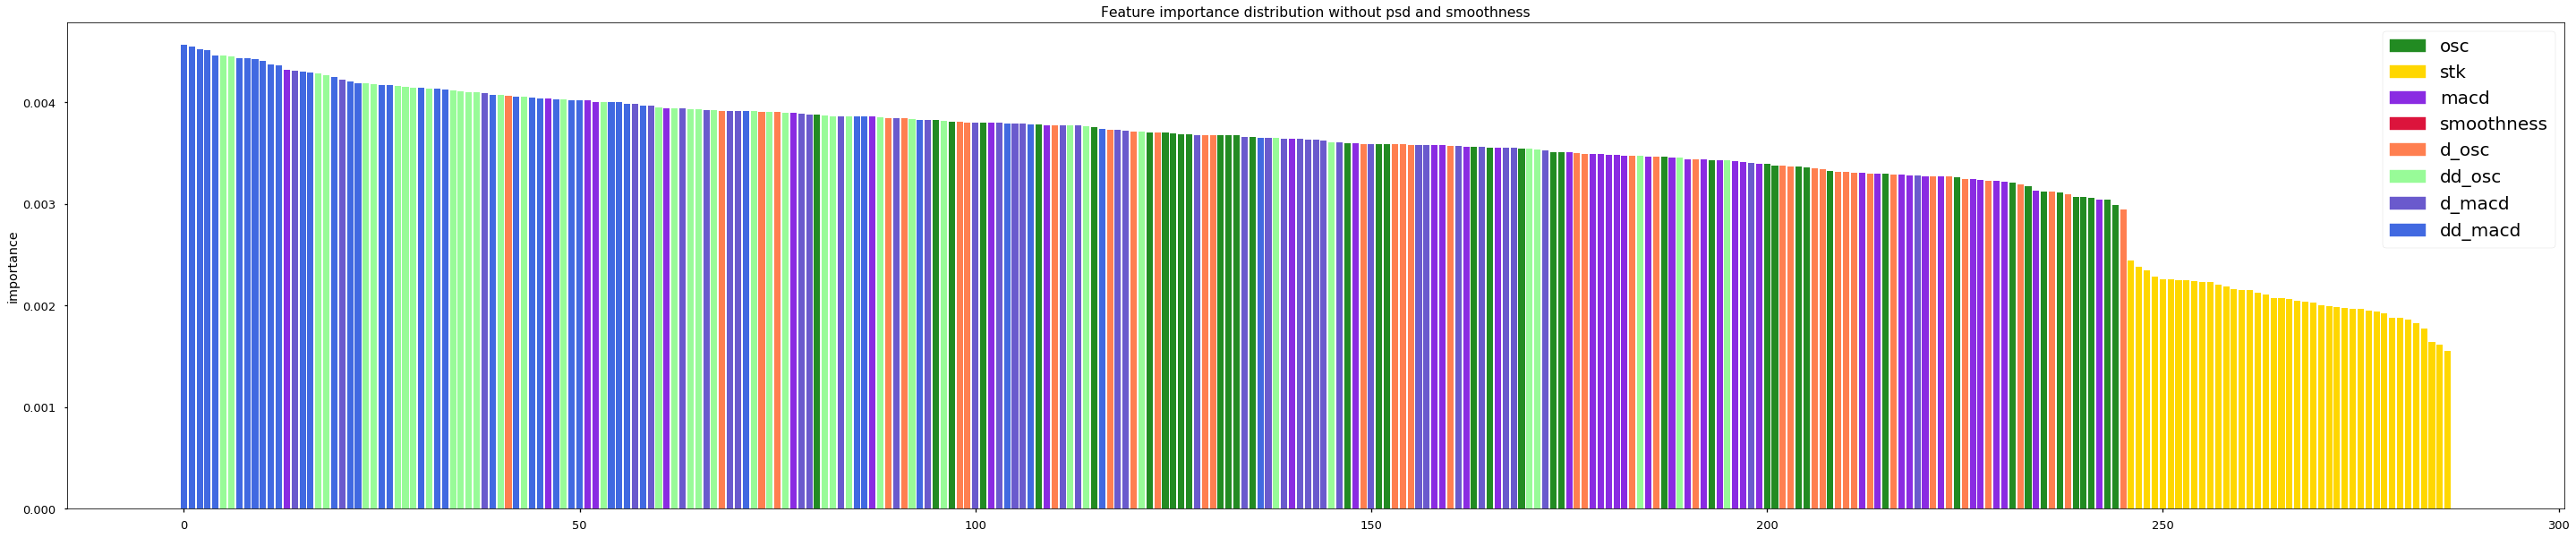

In [35]:
plt.figure(figsize=(50,10))

plt.bar(range(len(feature_importances["importance"].tolist())), feature_importances["importance"].tolist(), color = color)

osc = mpatches.Patch(color='forestgreen', label='osc')
stk = mpatches.Patch(color='gold', label='stk')
macd = mpatches.Patch(color='blueviolet', label='macd')
# smooth = mpatches.Patch(color='crimson', label='smoothness')
d_osc = mpatches.Patch(color='coral', label='d_osc')
dd_osc = mpatches.Patch(color='palegreen', label='dd_osc')
d_macd = mpatches.Patch(color='slateblue', label='d_macd')
dd_macd = mpatches.Patch(color='royalblue', label='dd_macd')

plt.ylabel("importance")
plt.title("Feature importance distribution without psd and smoothness")

plt.legend(handles=[osc,stk,macd,smooth,d_osc,dd_osc,d_macd,dd_macd], prop={'size': 20})
plt.show()

3. just use the base data (osc, stk, and macd)



In [36]:
OSC_base = OSC_analyzing_pipeline(data, "RandomForest")
OSC_base.features_generator(False, False, False, False, False)
OSC_base.model_train()

Validation Accuracy: 0.57 (+/- 0.00)
Test Accuracy: 0.5731171103021134


Text(0.5,1,'prediction curve (basic model)')

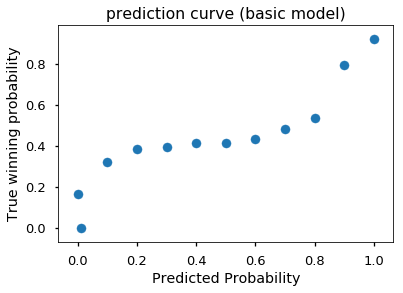

In [41]:
df_psd_cleaned = OSC_no_psd.report[OSC_no_psd.report["count"] > 5]
plt.scatter(df_psd_cleaned.index,df_psd_cleaned[["true_win_rate"]])
plt.xlabel("Predicted Probability")
plt.ylabel("True winning probability")
plt.title("prediction curve (basic model)")

LOL...

# Partial Smoothness

Actually, only the curve close to the signal point matters. Thus, it brings the question that: is it ture that only the smoothness of that part of curve matters?
Since we already proved above, the significancy of the model does not change too much when we reduce the number of features.

In [42]:
OSC_smooth_compare = OSC_analyzing_pipeline(data, "RandomForest")
OSC_smooth_compare.features_generator(False, True, False, False, True)
OSC_smooth_compare.model_train()


Validation Accuracy: 0.57 (+/- 0.00)
Test Accuracy: 0.5770412746442248


In [45]:
# OSC_smooth_compare.X.head()

In [44]:
feature_importances = pd.DataFrame({"features":OSC_smooth_compare.X.columns,"importance":OSC_smooth_compare.model.feature_importances_}).reset_index(drop=True).sort_values('importance',ascending=False)
col_index_list = feature_importances.index.tolist()
color = []
feature_type = []
for col in col_index_list:
    if col < 41:
        color.append("forestgreen")
        feature_type.append("osc")
    if (col > 40) & (col < 82):
        color.append("gold")
        feature_type.append("stk")
    if (col > 81) & (col < 123):
        color.append("blueviolet")
        feature_type.append("macd")
    #if (col > 122) & (col < 174):
        #color.append("blue")
        #feature_type.append("freq")
    if (col == 123):
        color.append("crimson")
        feature_type.append("smoothness")
    if (col == 124):
        color.append("coral")
        feature_type.append("10_points_smoothness")
    if (col == 125):
        color.append("palegreen")
        feature_type.append("20_points_smoothness")
    if (col == 126):
        color.append("slateblue")
        feature_type.append("30_points_smoothness")
    

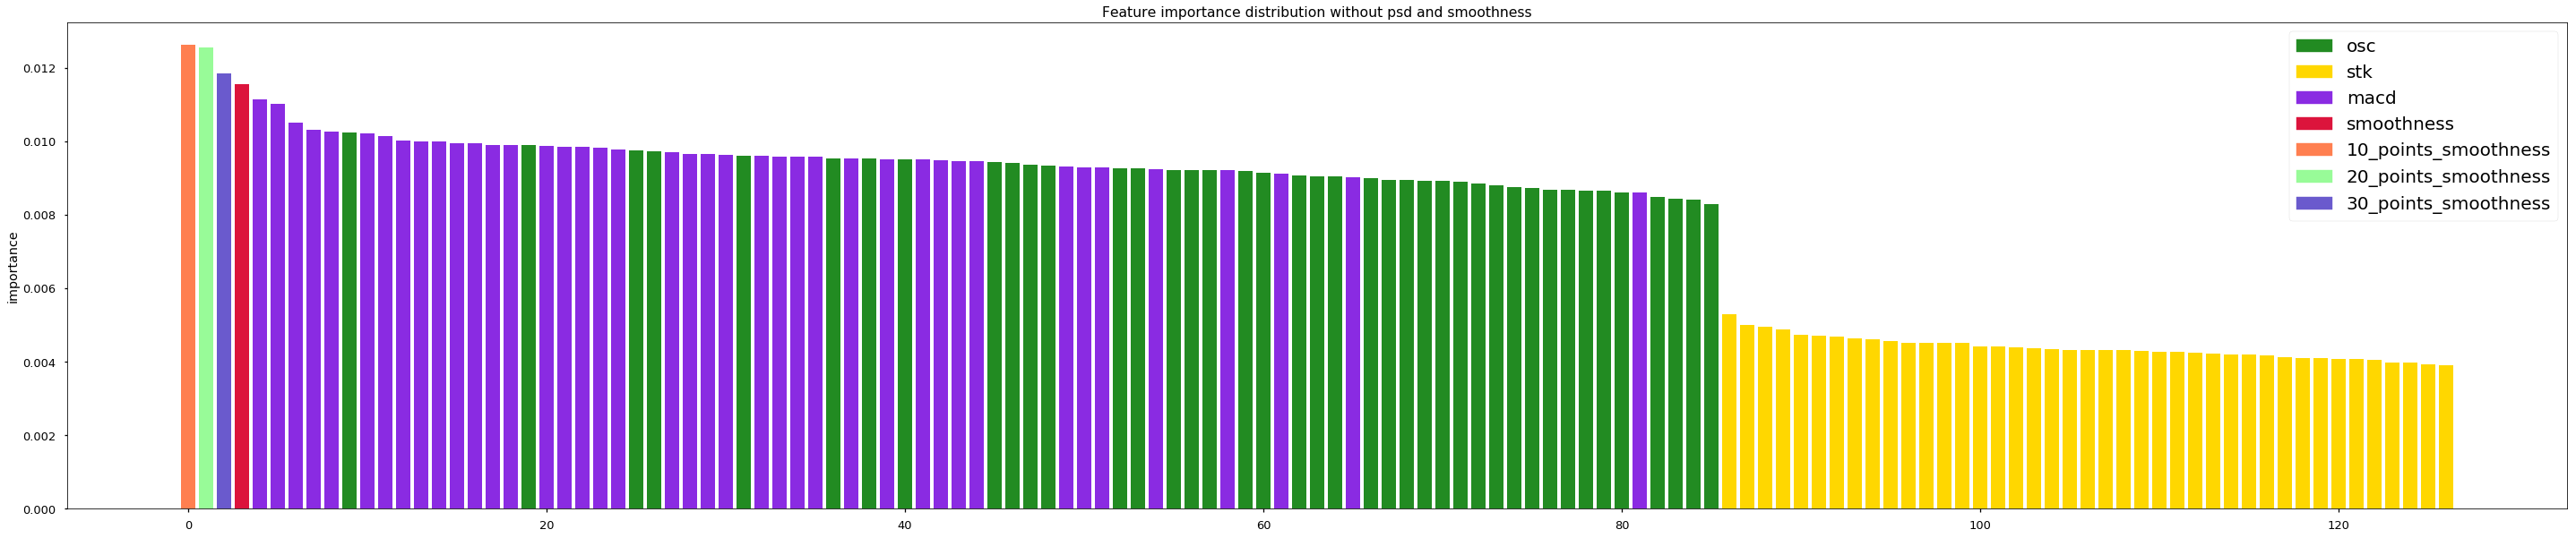

In [48]:
plt.figure(figsize=(50,10))

plt.bar(range(len(feature_importances["importance"].tolist())), feature_importances["importance"].tolist(), color = color)

osc = mpatches.Patch(color='forestgreen', label='osc')
stk = mpatches.Patch(color='gold', label='stk')
macd = mpatches.Patch(color='blueviolet', label='macd')
smooth = mpatches.Patch(color='crimson', label='smoothness')
smooth_10 = mpatches.Patch(color='coral', label='10_points_smoothness')
smooth_20 = mpatches.Patch(color='palegreen', label='20_points_smoothness')
smooth_30 = mpatches.Patch(color='slateblue', label='30_points_smoothness')


plt.ylabel("importance")
plt.title("Feature importance distribution without psd and smoothness")

plt.legend(handles=[osc,stk,macd,smooth,smooth_10,smooth_20,smooth_30], prop={'size': 20})
plt.show()

the importance of different smoothness.

In [54]:
smoothness_importance = feature_importances.iloc[:4,:]

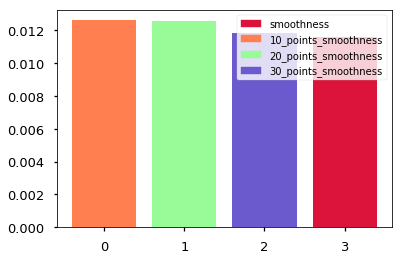

In [61]:
plt.bar(range(4), smoothness_importance["importance"].tolist()[0:5], color = color)
plt.legend(handles=[smooth,smooth_10,smooth_20,smooth_30], prop={'size': 10}, loc = "best")


# Hyperparameter tuning

This is only an explory study, so we only use the feature matrix (Full)

In [62]:
OSC_feature = OSC_analyzing_pipeline(data, "RandomForest")

In [63]:
OSC_feature.features_generator(True, True, True, True, True)

In [114]:
Feature_matrix = OSC_feature.feature_result_df
rf = RandomForestClassifier()

X,X_test,y,y_test = train_test_split(Feature_matrix.iloc[:,:-1], Feature_matrix.iloc[:,-1], test_size=0.2)

In [86]:
from sklearn.model_selection import GridSearchCV
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 100, num = 10)]

# Maximum number of levels in treew
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]
max_depth.append(None)
# Method of selecting samples for training each tree
# Create the random grid

random_grid = {'n_estimators': n_estimators,
               'max_depth': max_depth}
# print(random_grid)

In [91]:
rf_random = GridSearchCV(estimator = rf, param_grid = random_grid_test, cv = 3)

It takes enomous time to fit! (problem)

# Explore the hyperparameter on Accuracy

### n_estimators

In [97]:
# n_estimators
score_mean = []
score_sd = []
for n in n_estimators:
    model_temp = RandomForestClassifier(n_estimators=n)
    print("now training the model with n equals to ", n)
    model_temp.fit(X,y)
    scores_temp = cross_val_score(model_temp, X, y, cv=5)
    score_mean.append(scores_temp.mean())
    score_sd.append(scores_temp.std())
    print("Validation Accuracy: %0.4f (+/- %0.4f)" % (scores_temp.mean(), scores_temp.std() * 2))
    print("------------------------------------")
    print(" ")

now training the model with n equals to  10
Validation Accuracy: 0.5736 (+/- 0.0049)
------------------------------------
 
now training the model with n equals to  20
Validation Accuracy: 0.5815 (+/- 0.0052)
------------------------------------
 
now training the model with n equals to  30
Validation Accuracy: 0.5836 (+/- 0.0089)
------------------------------------
 
now training the model with n equals to  40
Validation Accuracy: 0.5853 (+/- 0.0034)
------------------------------------
 
now training the model with n equals to  50
Validation Accuracy: 0.5871 (+/- 0.0073)
------------------------------------
 
now training the model with n equals to  60
Validation Accuracy: 0.5906 (+/- 0.0030)
------------------------------------
 
now training the model with n equals to  70
Validation Accuracy: 0.5934 (+/- 0.0045)
------------------------------------
 
now training the model with n equals to  80
Validation Accuracy: 0.5934 (+/- 0.0023)
------------------------------------
 
now trai

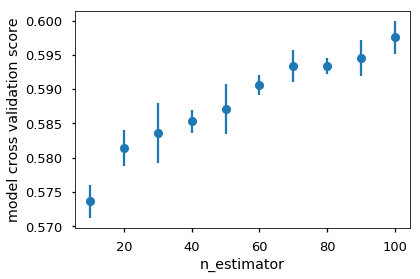

In [99]:
plt.errorbar(n_estimators, score_mean, yerr=score_sd, fmt='o')
plt.xlabel("n_estimator")
plt.ylabel("model cross validation score")
plt.show()

### max_depth

In [102]:
md_score_mean = []
md_score_sd = []
for n in max_depth:
    model_temp = RandomForestClassifier(n_estimators = 100, max_depth=n)
    print("now training the model with n equals to ", n)
    model_temp.fit(X,y)
    scores_temp = cross_val_score(model_temp, X, y, cv=5)
    md_score_mean.append(scores_temp.mean())
    md_score_sd.append(scores_temp.std())
    print("Validation Accuracy: %0.4f (+/- %0.4f)" % (scores_temp.mean(), scores_temp.std() * 2))
    print("------------------------------------")
    print(" ")

now training the model with n equals to  10
Validation Accuracy: 0.5927 (+/- 0.0011)
------------------------------------
 
now training the model with n equals to  20
Validation Accuracy: 0.6019 (+/- 0.0029)
------------------------------------
 
now training the model with n equals to  30
Validation Accuracy: 0.5976 (+/- 0.0029)
------------------------------------
 
now training the model with n equals to  40
Validation Accuracy: 0.5968 (+/- 0.0033)
------------------------------------
 
now training the model with n equals to  50
Validation Accuracy: 0.5946 (+/- 0.0065)
------------------------------------
 
now training the model with n equals to  60
Validation Accuracy: 0.5949 (+/- 0.0017)
------------------------------------
 
now training the model with n equals to  70
Validation Accuracy: 0.5956 (+/- 0.0052)
------------------------------------
 
now training the model with n equals to  80
Validation Accuracy: 0.5967 (+/- 0.0027)
------------------------------------
 
now trai

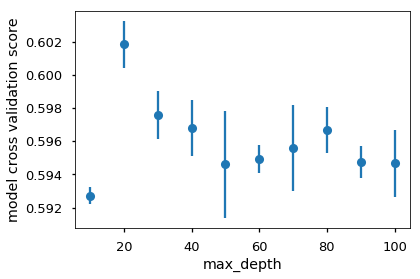

In [107]:
plt.errorbar(max_depth[:-1], md_score_mean[:-1], yerr=md_score_sd[:-1], fmt='o')
plt.xlabel("max_depth")
plt.ylabel("model cross validation score")
plt.show()

# Explore the hyperparameter on grouping

In [154]:
def n_estimator_report(n):
    rf = RandomForestClassifier(n_estimators = n, max_depth = 20)
    rf.fit(X,y)
    prob = rf.predict_proba(X)
    prob_1 = []
    for probs in prob:
        prob_1.append(probs[1])
    df_result = pd.DataFrame({"predicted_prob":prob_1,
                             "true_label": y})
    df_count = df_result.groupby("predicted_prob").count()
    df_win = df_result.groupby("predicted_prob").sum()
    
    report = pd.DataFrame(df_win/df_count[["true_label"]]).sort_index(ascending = False)
    report["count"] = df_count
    report.columns = ["true_win_rate", "count"]
    return report

In [155]:
n_estimator_report(5)

,true_win_rate,count
predicted_prob,,
1.000000,1.0,528
0.997590,1.0,6
0.997500,1.0,2
0.997059,1.0,1
0.995918,1.0,1
0.995652,1.0,1
0.995556,1.0,1
0.995122,1.0,4
0.994872,1.0,4


In [156]:
n_estimator_report(10)

,true_win_rate,count
predicted_prob,,
1.000000,1.0,58
0.998387,1.0,1
0.997619,1.0,1
0.997368,1.0,3
0.996875,1.0,1
0.996429,1.0,1
0.996226,1.0,1
0.996104,1.0,1
0.994643,1.0,2


In [125]:
n_estimator_report(15)

,true_win_rate,count
predicted_prob,,
1.000000,1.0,2
0.998095,1.0,2
0.965203,1.0,1
0.944908,1.0,1
0.919504,1.0,1


In [123]:
n_estimator_report(20)

,true_win_rate,count
predicted_prob,,
0.978619,1.0,1
0.967615,1.0,2
0.932499,1.0,1
0.926689,1.0,2
0.909679,1.0,1


In [124]:
n_estimator_report(25)

,true_win_rate,count
predicted_prob,,
0.978901,1.0,1
0.964813,1.0,1
0.964807,1.0,2
0.958325,1.0,2
0.942755,1.0,1


We can futher modify the function and see how many prediction is above 90%

In [157]:
n_estimators = list(range(5,55,5))
count_rec = []
for n in n_estimators:
    print("Now running n =", n)
    report = n_estimator_report(n)
    count_total = 0
    prob_list = report.index.tolist()
    count_list = report["count"].tolist()
    for i in range(len(prob_list)):
        if prob_list[i] > 0.9:
            count_total += count_list[i]
    count_rec.append(count_total)

Now running n = 5
Now running n = 10
Now running n = 15
Now running n = 20
Now running n = 25
Now running n = 30
Now running n = 35
Now running n = 40
Now running n = 45
Now running n = 50


Text(0,0.5,'Count for prediction above 90% (trainset)')

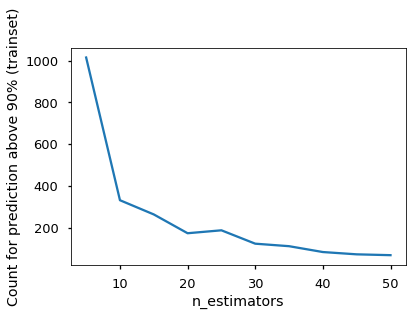

In [159]:
plt.plot(n_estimators, count_rec)
plt.xlabel("n_estimators")
plt.ylabel("Count for prediction above 90% (trainset)")


In [160]:
max_depth = [int(x) for x in np.linspace(10, 100, num = 10)]

def max_depth_report(n):
    rf = RandomForestClassifier(n_estimators = 25, max_depth = n)
    rf.fit(X,y)
    prob = rf.predict_proba(X)
    prob_1 = []
    for probs in prob:
        prob_1.append(probs[1])
    df_result = pd.DataFrame({"predicted_prob":prob_1,
                             "true_label": y})
    df_count = df_result.groupby("predicted_prob").count()
    df_win = df_result.groupby("predicted_prob").sum()
    
    report = pd.DataFrame(df_win/df_count[["true_label"]]).sort_index(ascending = False)
    report["count"] = df_count
    report.columns = ["true_win_rate", "count"]
    return report

In [164]:
count_rec_md = []
for n in max_depth:
    print("Now running n =", n)
    report = max_depth_report(n)
    count_total = 0
    prob_list = report.index.tolist()
    count_list = report["count"].tolist()
    for i in range(len(prob_list)):
        if prob_list[i] > 0.9:
            count_total += count_list[i]
    count_rec_md.append(count_total)

Now running n = 10
Now running n = 20
Now running n = 30
Now running n = 40
Now running n = 50
Now running n = 60
Now running n = 70
Now running n = 80
Now running n = 90
Now running n = 100


Text(0,0.5,'Count for prediction above 90% (trainset)')

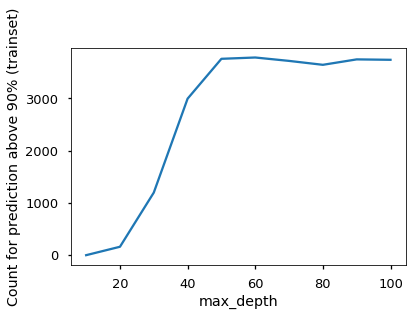

In [165]:
plt.plot(max_depth, count_rec_md)
plt.xlabel("max_depth")
plt.ylabel("Count for prediction above 90% (trainset)")



Conclusion: n_estimator = 20 or 25, max_depth = 80?